# Data Wrangling

For this analysis we will look at respective household income extremes in republican vs democratic districts. To do so, we will leverage two data sources that we will need to combine together. 

First, we will use the American Community Survey 2021 dataset available from census.gov. The data is available via API from here: https://www.census.gov/data/developers/data-sets/acs-1year.html. This data is commonly referenced when people are looking for demographic breakdowns of the American population. This data refers back to the 116th congressional district. 

Second, to get the party affiliation of each congressional district, we will use https://www.house.gov/representatives. Someone has already scraped the house.gov site to turn it into a csv here: http://goodcsv.com/politics/us-house-of-representatives-2020/ for the 116th congressional district.


In [1]:
# first some initial setup of libraries we will be using
import pandas as pd # this is the main library used in python for manipulating data. 
import json # this is a library to parse json (javascript object notation)
from urllib.request import urlopen # library to read data from a URL
import matplotlib.pyplot as plt # visualization library we will use that integrates with pandas

First we will read the ACS 2021 dataset and get it into a usable state for our data analysis.

In [2]:
# We are reading in the data we want from ACS 2021. The API returns json data. Try copy and pasting the link yourself in a browser to see what the raw data looks like.
url="https://api.census.gov/data/2021/acs/acs1?get=NAME,B19001_001E,B19001_002E,B19001_017E&for=congressional%20district:*&in=state:*"

# store the response of URL
response = urlopen(url)

# storing the JSON response from url in data
data_json = json.loads(response.read())
data_json.pop(0) # the first row of data is header information which we don't need, so pop removes that from the dataset.

# Hand populate the columns based on the variable descriptions census.gov documents here:
# https://api.census.gov/data/2021/acs/acs1/variables.html. Note they correspond back to the variable names I included in the URL above.
cols = ['District Name','Total Households','Less than $10k', '$200k+', 'State code', 'district number']

acs_df = pd.DataFrame(data_json, columns = cols)

# time to do some basic cleanup of the data. We will need to extract the district number and state in a regular format so we can later join with the party data.
acs_df[['District', 'State']] = acs_df['District Name'].str.split(',', expand=True)
acs_df['district number'] = pd.to_numeric(acs_df['district number'])

acs_df['State'] = acs_df['State'].str.strip()

# Let's just keep the columns we need
acs_df = acs_df[['Total Households', 'Less than $10k', "$200k+", 'district number', 'State']]

# take a look at the top results in the dataset
acs_df.head()

,Total Households,Less than $10k,$200k+,district number,State
0,289474,14153,19390,10,Michigan
1,299804,23793,10899,4,Mississippi
2,278057,27728,19574,14,Michigan
3,306685,19036,12208,1,Michigan
4,285554,26481,12412,3,Mississippi


In [3]:

# Convert the number columns into number data types so we can math on them
acs_df["Total Households"] = pd.to_numeric(acs_df["Total Households"])
acs_df["Less than $10k"] = pd.to_numeric(acs_df["Less than $10k"])
acs_df['$200k+'] = pd.to_numeric(acs_df['$200k+'])

# Compute some new columns based on the existing columns for later visualization
acs_df['% of households over $200k'] = (100*acs_df['$200k+'])/acs_df['Total Households']
acs_df['% of households less than $10k'] = (100*acs_df['Less than $10k'])/acs_df['Total Households']

# now let's look at the data again
acs_df.head()

,Total Households,Less than $10k,$200k+,district number,State,% of households over $200k,% of households less than $10k
0,289474,14153,19390,10,Michigan,6.698356,4.889213
1,299804,23793,10899,4,Mississippi,3.635375,7.936185
2,278057,27728,19574,14,Michigan,7.039564,9.972056
3,306685,19036,12208,1,Michigan,3.980632,6.207020
4,285554,26481,12412,3,Mississippi,4.346638,9.273552


In [4]:
state_acs = acs_df.groupby(by=["State"]).sum()[['Total Households','Less than $10k', '$200k+']]
state_acs = state_acs.reset_index()

In [5]:
state_acs['% of households over $200k'] = state_acs['$200k+']/state_acs['Total Households']
state_acs['% of households less than $10k'] = state_acs['Less than $10k']/state_acs['Total Households']

In [6]:
state_acs

,State,Total Households,Less than $10k,$200k+,% of households over $200k,% of households less than $10k
0,Alabama,1967559,152450,101831,0.051755,0.077482
1,Alaska,271311,14625,27700,0.102097,0.053905
2,Arizona,2817723,158400,228651,0.081147,0.056216
3,Arkansas,1183675,89818,55972,0.047287,0.075881
4,California,13429063,715644,2082043,0.155040,0.053291
5,Colorado,2313042,110592,277905,0.120147,0.047812
6,Connecticut,1428313,74573,208195,0.145763,0.052211
7,Delaware,395656,20504,33025,0.083469,0.051823
8,District of Columbia,319565,30677,68951,0.215765,0.095996
9,Florida,8565329,542819,663997,0.077521,0.063374


In [7]:
#Remove Puerto Rico as state
state_acs = state_acs[(state_acs['State'] != "Puerto Rico") & (state_acs['State'] != "District of Columbia")]

Now let's get our party affiliation data in a state to merge with the ACS data.

In [8]:
shoot_df = pd.read_csv("mass_shootings_2021.csv")
shoot_df['Victims Total'] = shoot_df['Victims Killed'] + shoot_df['Victims Injured']
shoot_df["Shooting Count"] = 1 #Useful for later graph

In [9]:
shoot_df.sort_values(by="Victims Total", ascending=False)

,Incident ID,Incident Date,State,City Or County,Address,Victims Killed,Victims Injured,Suspects Killed,Suspects Injured,Suspects Arrested,Operations,Victims Total,Shooting Count
454,2019622,"May 30, 2021",Florida,Hialeah,7630 NW 186th St,3,20,0,0,1,NaN,23,1
544,1978635,"April 15, 2021",Indiana,Indianapolis,8951 Mirabel Rd,8,7,1,0,0,NaN,15,1
468,2012765,"May 22, 2021",South Carolina,North Charleston,Piggly Wiggly Dr and W Jimtown Dr,1,14,0,0,4,NaN,15,1
600,1952281,"March 14, 2021",Illinois,Chicago,6798 block of S South Chicago Ave,2,13,0,0,0,NaN,15,1
173,2123395,"September 23, 2021",Tennessee,Collierville,240 New Byhalia Rd,1,14,1,0,0,NaN,15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,2122565,"September 22, 2021",North Carolina,Fayetteville,1100 block of Charlie Dr,2,2,0,0,0,NaN,4,1
412,2038152,"June 17, 2021",New Jersey,Paterson,Rosa Parks Blvd and Hamilton Ave,0,4,0,0,0,NaN,4,1
411,2038622,"June 17, 2021",Ohio,Cincinnati,3056 Mathers St,1,3,0,0,0,NaN,4,1
410,2037887,"June 17, 2021",North Carolina,Durham,1600 block of Holloway St,2,2,0,0,0,NaN,4,1


In [10]:
shoot_sum = shoot_df.groupby(by=["State"]).sum()
shoot_sum = shoot_sum.reset_index()

In [11]:
# Merge is like a sql natural join. We are joining on the State and District numbers being the same between the two sets.
merged_sum_df = pd.merge(state_acs, shoot_sum, on=["State"], how = "left")

In [12]:
#Fill in 0 values so they still appear
merged_sum_df = merged_sum_df.fillna(0)

In [13]:
merged_sum_df['Victims Proportion'] = 100*merged_sum_df['Victims Total']/merged_sum_df['Total Households']

In [14]:
merged_sum_df.columns

Index(['State', 'Total Households', 'Less than $10k', '$200k+',
       '% of households over $200k', '% of households less than $10k',
       'Incident ID', 'Incident Date', 'City Or County', 'Address',
       'Victims Killed', 'Victims Injured', 'Suspects Killed',
       'Suspects Injured', 'Suspects Arrested', 'Operations', 'Victims Total',
       'Shooting Count', 'Victims Proportion'],
      dtype='object')

In [15]:
merged_sum_df[['State','Victims Total', 'Less than $10k', '$200k+', '% of households over $200k','% of households less than $10k']].sort_values(by="Victims Total",ascending=False)

,State,Victims Total,Less than $10k,$200k+,% of households over $200k,% of households less than $10k
12,Illinois,442.0,321928,504727,0.101114,0.064493
42,Texas,296.0,657665,955952,0.088545,0.060916
4,California,221.0,715644,2082043,0.155040,0.053291
8,Florida,181.0,542819,663997,0.077521,0.063374
31,New York,168.0,535006,987887,0.129091,0.069911
34,Ohio,167.0,317928,312314,0.064622,0.065784
37,Pennsylvania,167.0,308449,454003,0.086825,0.058989
17,Louisiana,164.0,164981,101388,0.056834,0.092482
21,Michigan,123.0,256830,273320,0.067456,0.063387
9,Georgia,115.0,251693,337914,0.084455,0.062906


In [16]:
merged_sum_df["Victims per Shooting"] = merged_sum_df["Victims Total"] / merged_sum_df["Shooting Count"]

## Party Data Merging

In [17]:
# Replace the URL with the Wikipedia page URL containing the table
url = "https://en.wikipedia.org/wiki/Political_party_strength_in_U.S._states#U.S._state_party_control_as_of_January_2024"
tables = pd.read_html(url, header=0)  # Set header=0 to use the first row as column names

# Select the desired table by index (if there are multiple tables on the page)
# You can print(tables) to see a list of all tables and their indices
selected_table_index = 2
party = tables[selected_table_index]
party = party[['State', '2020 presidential election']]
party.rename(columns={'2020 presidential election': 'Party'}, inplace=True)

C:\Users\diamo\AppData\Local\Temp\ipykernel_65112\1946194368.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  party.rename(columns={'2020 presidential election': 'Party'}, inplace=True)


In [18]:
merged_party_df = pd.merge(merged_sum_df,party, on=["State"], how = "left")

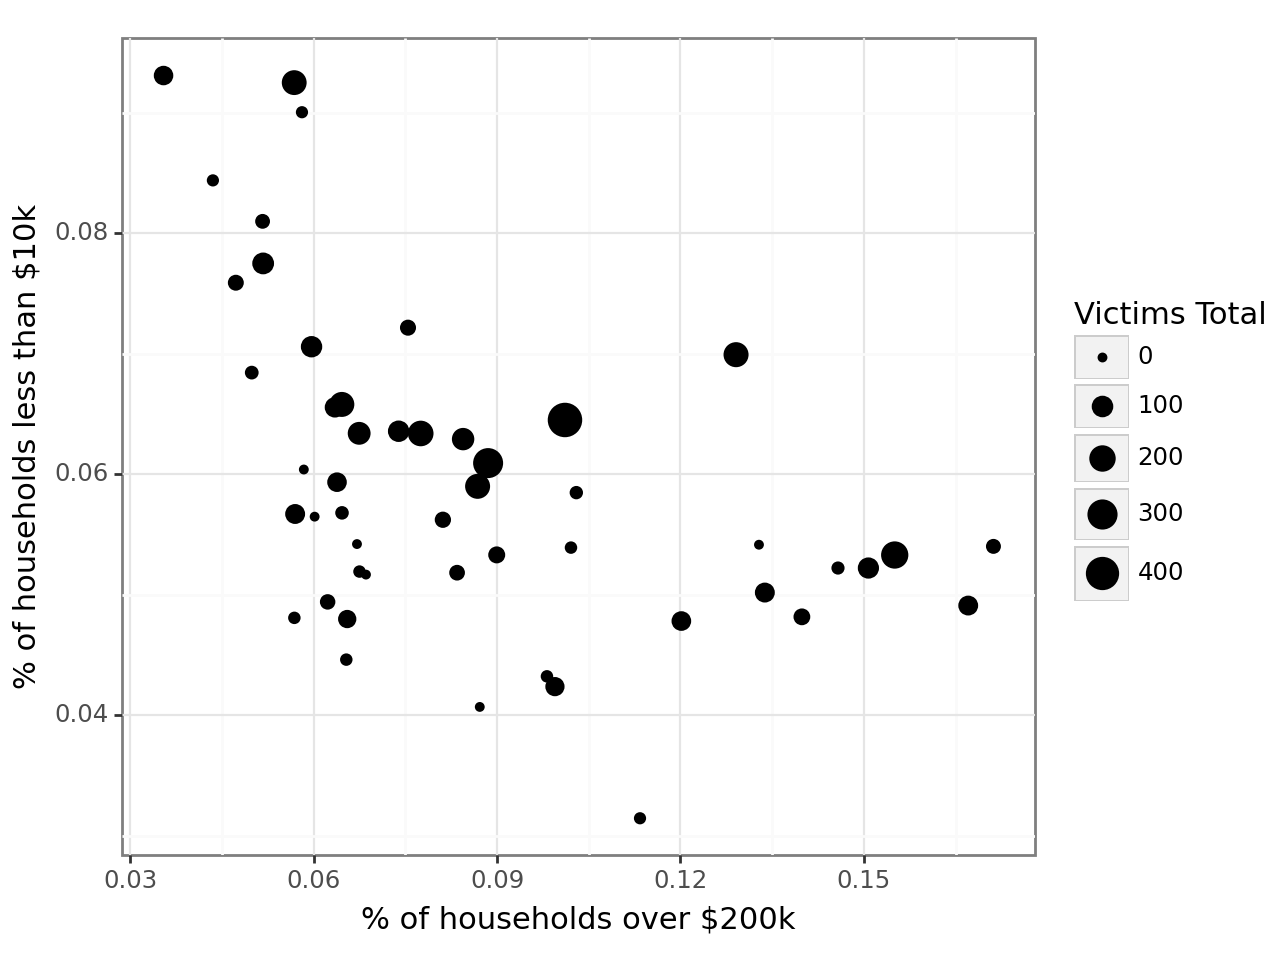

<Figure Size: (640 x 480)>

In [19]:
from plotnine import ggplot, aes, geom_boxplot, labs, scale_fill_discrete, scale_x_discrete, scale_fill_discrete, theme, element_text, theme_bw, geom_point
from plotnine.scales import scale_y_log10

(ggplot(merged_sum_df, aes(x="% of households over $200k", y="% of households less than $10k", size="Victims Total")) 
 + geom_point() #makes boxplots
 + labs(
   x="% of households over $200k",
   y="% of households less than $10k",
   title=""
 )
 + theme_bw() #white background theme rather than gray
 )


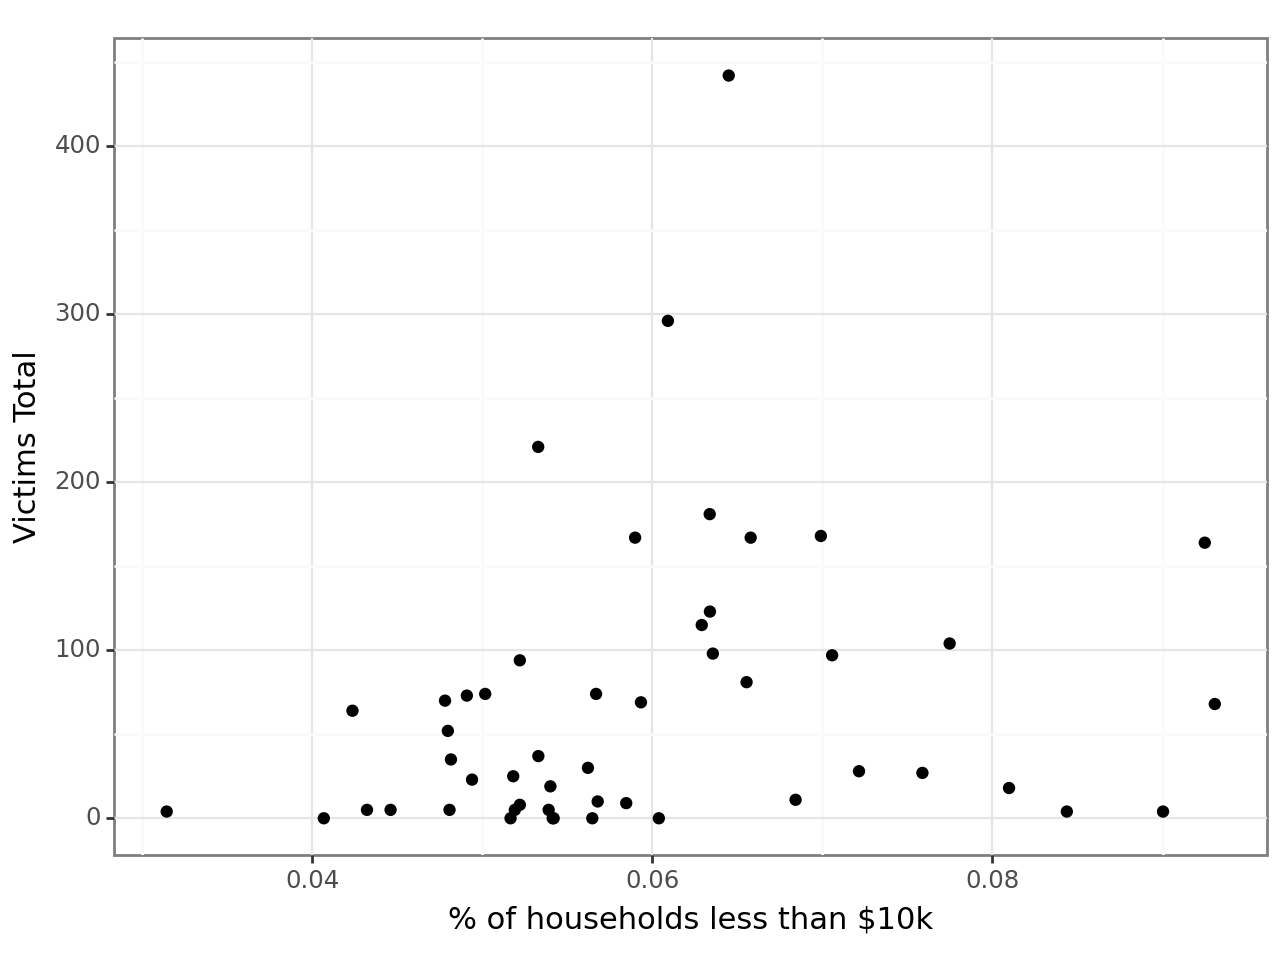

<Figure Size: (640 x 480)>

In [20]:
from plotnine import ggplot, aes, geom_boxplot, labs, scale_fill_discrete, scale_x_discrete, scale_fill_discrete, theme, element_text, theme_bw, geom_point
from plotnine.scales import scale_y_log10

(ggplot(merged_sum_df, aes(x="% of households less than $10k", y="Victims Total")) 
 + geom_point() #makes boxplots
 + labs(
   x="% of households less than $10k",
   y="Victims Total",
   title=""
 )
 + theme_bw() #white background theme rather than gray
 )


# Final Results

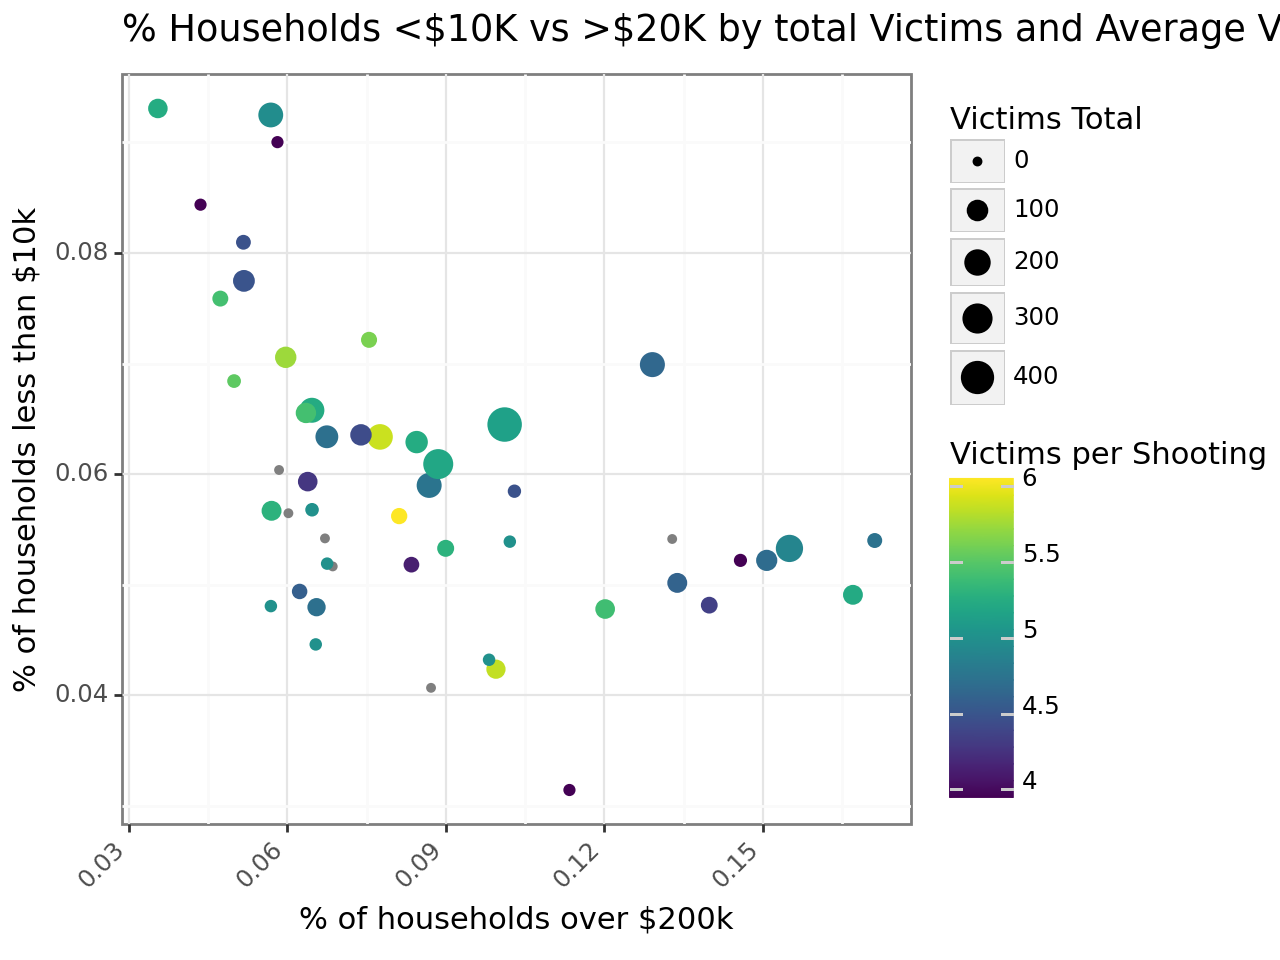

<Figure Size: (640 x 480)>

In [21]:
from plotnine import ggplot, aes, geom_boxplot, labs, scale_fill_discrete, scale_x_discrete, scale_fill_discrete, theme, element_text, theme_bw, geom_point, scale_fill_manual

(ggplot(merged_sum_df, aes(x="% of households over $200k", y="% of households less than $10k", size="Victims Total", color="Victims per Shooting")) 
 + geom_point() #makes boxplots
 + scale_fill_discrete(guide=False) #one of several ways to remove the automatic legend created
 + labs(
   x="% of households over $200k",
   y="% of households less than $10k",
   title="% Households <\$10K vs >\$20K by total Victims and Average Victims"
 )
 + theme_bw() #white background theme rather than gray
 + theme(axis_text_x=element_text(rotation=45, hjust=1)) #tilt the axis labels to not overlap
)

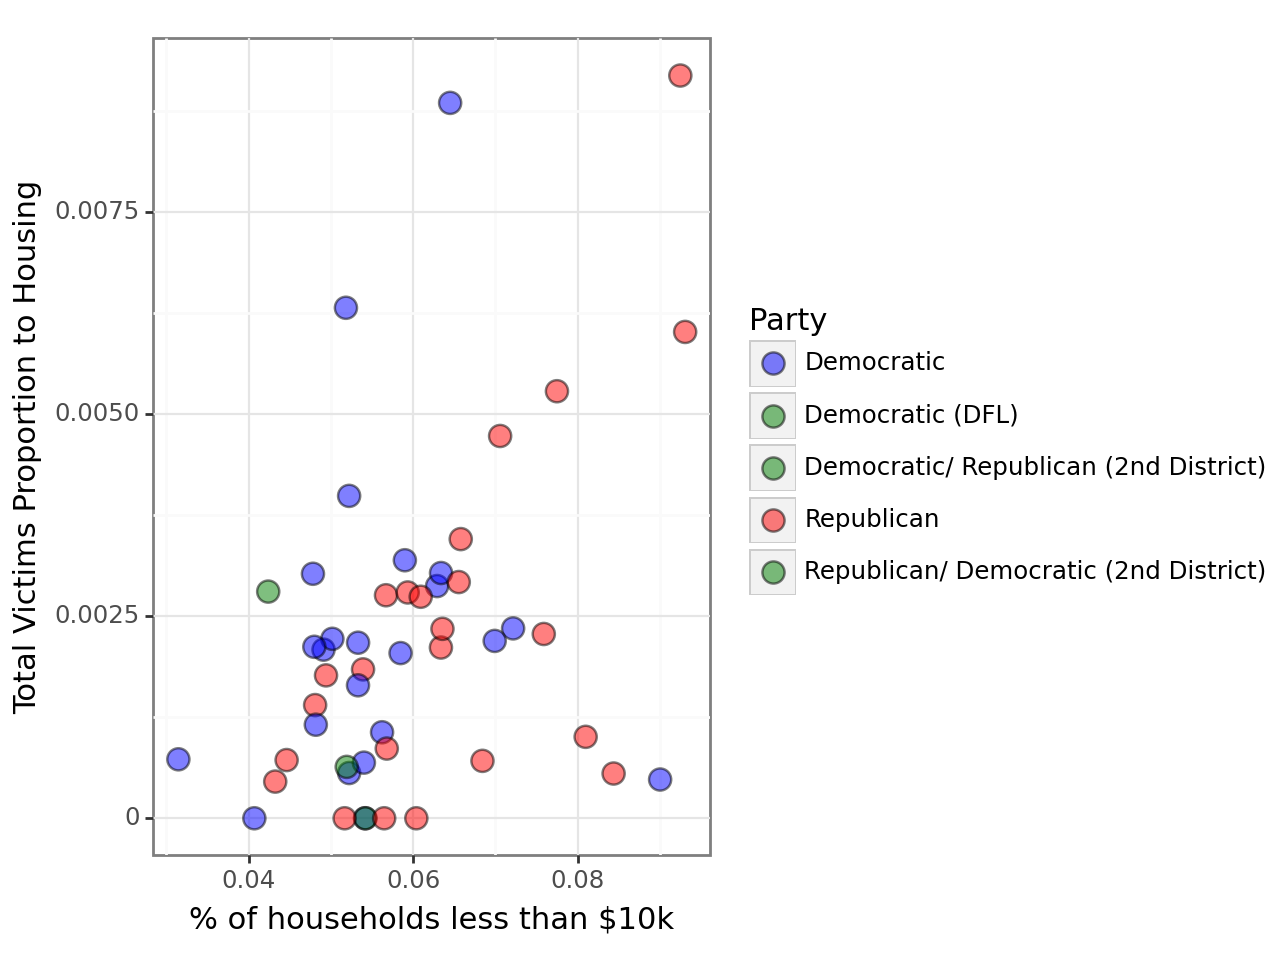

<Figure Size: (640 x 480)>

In [22]:
(ggplot(merged_party_df, aes(x="% of households less than $10k", y="Victims Proportion", fill='Party')) 
 + geom_point(size=4,alpha=.5) #makes boxplots
 + labs(
   x="% of households less than $10k",
   y="Total Victims Proportion to Housing",
   title=""
 )
 + theme_bw() #white background theme rather than gray
 + scale_fill_manual(values={'Democratic': 'blue', 'Republican': 'red', 'Democratic (DFL)': 'green', 'Democratic/ Republican (2nd District)': 'green', 'Republican/ Democratic (2nd District)': 'green'})
 #+ stat_smooth(method='lm')
 )

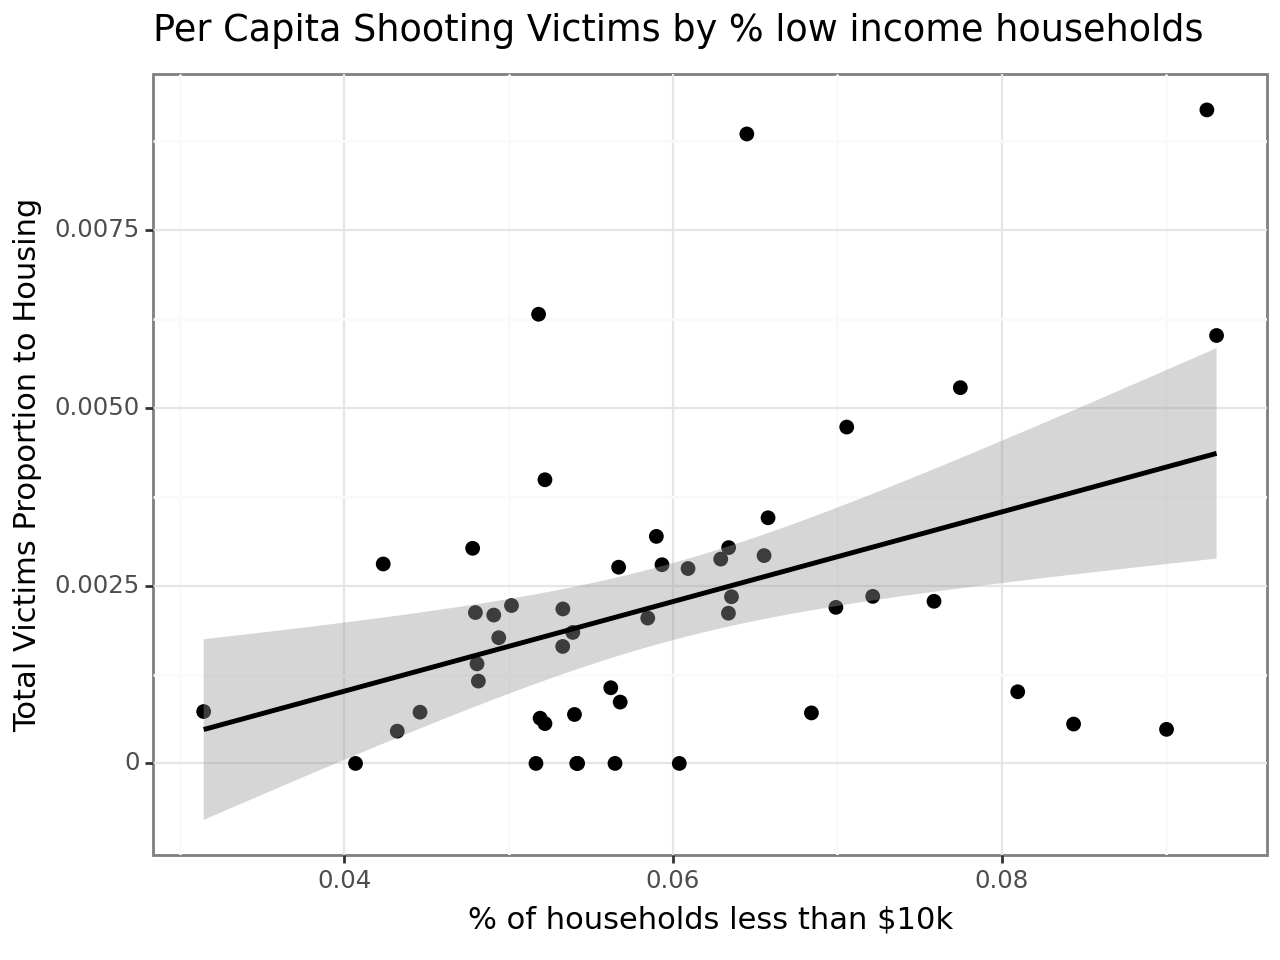

<Figure Size: (640 x 480)>

In [23]:
from plotnine import ggplot, aes, geom_boxplot, labs, scale_fill_discrete, scale_x_discrete,scale_fill_discrete, theme, element_text, theme_bw, geom_point,stat_smooth

(ggplot(merged_sum_df, aes(x="% of households less than $10k", y="Victims Proportion")) 
 + geom_point(size=2) #makes boxplots
 + labs(
   x="% of households less than $10k",
   y="Total Victims Proportion to Housing",
   title="Per Capita Shooting Victims by % low income households"
 )
 + theme_bw() #white background theme rather than gray
 + stat_smooth(method='lm')
 )


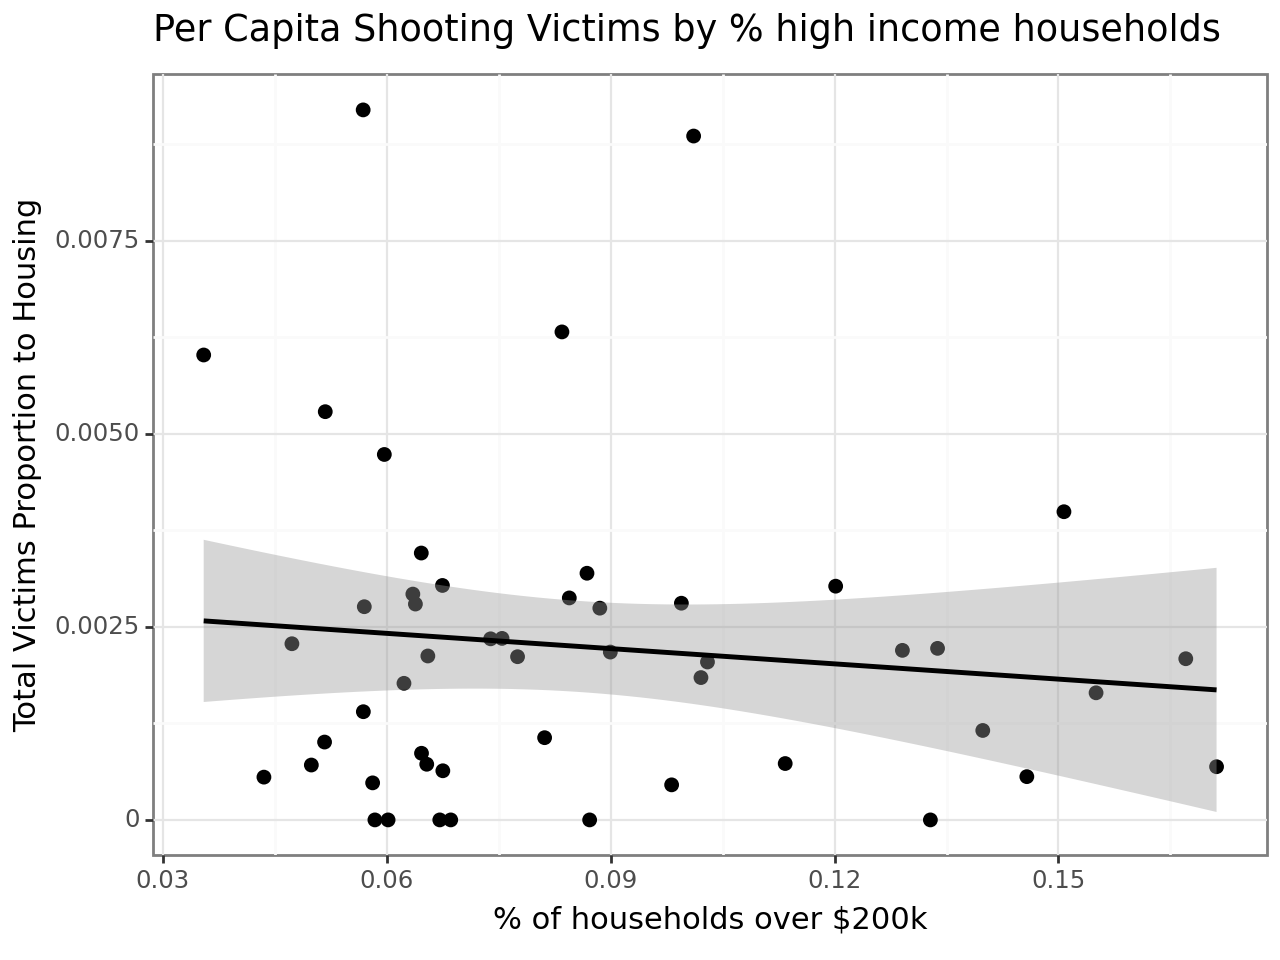

<Figure Size: (640 x 480)>

In [24]:
from plotnine import ggplot, aes, geom_boxplot, labs, scale_fill_discrete, scale_x_discrete,scale_fill_discrete, theme, element_text, theme_bw, geom_point,stat_smooth
from plotnine.scales import scale_y_log10

(ggplot(merged_sum_df, aes(x="% of households over $200k", y="Victims Proportion")) 
 + geom_point(size=2) #makes boxplots
 + labs(
   x="% of households over $200k",
   y="Total Victims Proportion to Housing",
   title="Per Capita Shooting Victims by % high income households"
 )
 + theme_bw() #white background theme rather than gray
 + stat_smooth(method='lm')
 )
